# Time-stepping with `expsolve.solvediffeq` 

In this notebook we will learn how to

* solving a PDE on a timegrid, given a time stepper (`timegrid`, `solvediffeq`),
* computing observables,
* estimating order of convergence in time (`order`).

[Back to evolve quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag
from torch.linalg import matrix_exp

## Solving the PDE using `solvediffeq`

### Grid & Initial Condition

In [12]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

### Strang splitting

As described in `tensorgrid` tutorials, a single step of Strang splitting is

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

In [13]:
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda t, h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

### Time propagation

#### $\star$ `timegrid`, `solvediffeq`

We create a time grid with `timegrid`

```Python
    es.timegrid(trange, ndt)
```
where `trange` should be a tuple of initial and final time `(t0, t1)`, while `ndt` is the number of time-steps. `timegrid` returns a `torch` array of length `ndt+1`.

Once the stepper is ready, we can use `solvediffeq` to solve the PDE on a `timegrid`. 

```Python
    uT, _, _ = es.solvediffeq(u0, timegrid, stepper)
```

where `stepper` should be a function `stepper(t, h, un)` which returns an approximation of $u(t+h)$ given $u(t)=un$. The final output at time `t1` is given by `uT`.

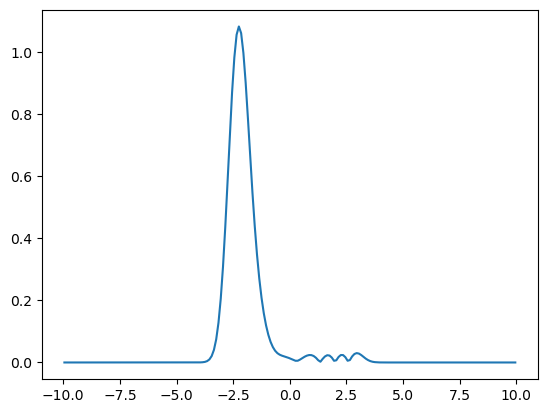

In [14]:
trange = [0, 1]
timegrid = es.timegrid(trange, ndt=100)
ustrangT, _, _ = es.solvediffeq(u, timegrid, strang)
ex.plot(plt, x, abs(ustrangT))
plt.show()

We compare this to the brute force solution using `matrix_exp`

In [15]:
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
urefT = es.linalg.matmul(matrix_exp(-1j * (trange[1]-trange[0]) *H) , u)
print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

The L2 error in Strang splitting is tensor([0.0017], dtype=torch.float64)


## Computing Observables

Recall that observables are implemented using the `observable` function, the syntax of which is:

```Python
    ex.observable(obs, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `obs` is a Hermitian operator or matrix. 

For instance, the position operator is multiplication by $x$ which is achieved as `lambda psi: x*psi` and the momentum operator is multiplication by $-i$ and 1st derivative operation. Let us put these in a dictionary:

In [16]:
observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

If observable values are desired, we pass the dictionary of functions for computing observables in the optional `observables` parameter  to `solvediffeq`

```Python
    uT, obsvalues, _ = es.solvediffeq(u0, timegrid, stepper, observables=observables)
```

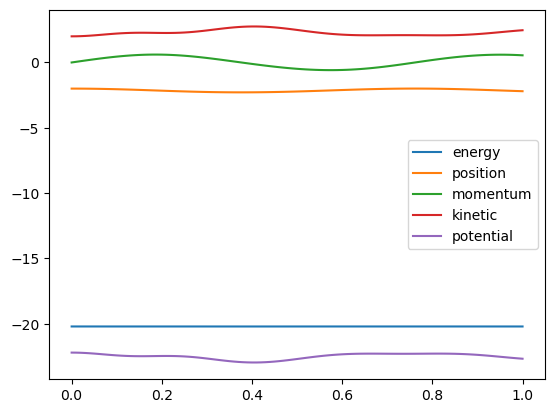

In [17]:
ustrangT, obsvalues, _ = es.solvediffeq(u, timegrid, strang, observables=observables)
ex.obsplot(plt, timegrid, obsvalues)

## Storing intermediate values

If intermediate values are required, they can be obtained by setting the optional parameter `storeintermediate` to `True`

In [18]:
ustrangT, _, uintermediate = es.solvediffeq(u, timegrid, strang, storeintermediate=True)

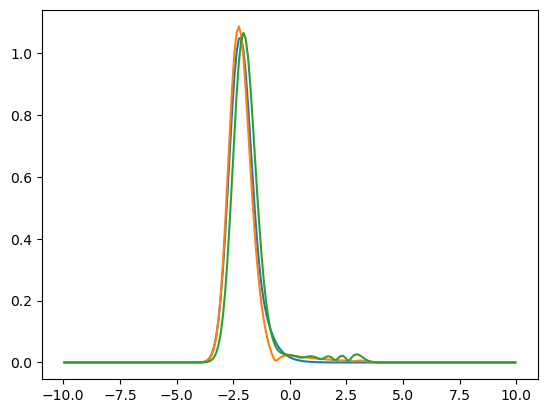

In [19]:
ex.plot(plt, x, abs(uintermediate[20]))
ex.plot(plt, x, abs(uintermediate[50]))
ex.plot(plt, x, abs(uintermediate[80]))
plt.show()

## Analysing convergence order of a stepper (in time)

#### $\star$ `order`

If a reference solution is available, we can analyse the convergence order (in time) of a time stepping method using `order`:

```Python
    ord, err = es.order(u, uref, normfn, trange, ndtlist, steppers)
```
where `normfn(ucand, uref)` should compute the desired error, and `ndtlist` should be a list of number of timesteps for which the method will be tested for convergence. 

The optional parameter `showplot` can be set to `False` to suppress display of plots.

The `steppers` parameter should be a dictionary of `{'methodname' : steppefn}` format. This list should be length $3$ or more. The function returns dictionary `ord`, which is an estimate (rounded to the nearest half order, e.g. 1.0, 1.5, 3.0) of the order of convergence for each `stepperfn`, as well as `err`, which is a dictionary of the errors for different time steps for each `stepperfn`.

order of the Strang splitting is 2.0


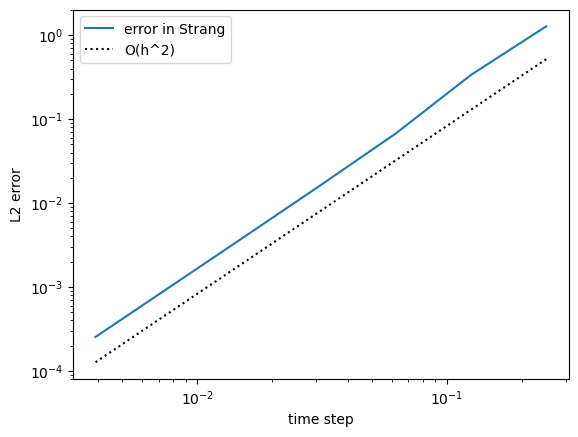

In [20]:
normfn = lambda u0, u1: ex.l2norm(u0-u1, xr)
ord, _ = es.order(u, urefT, normfn, trange, ndtlist=2**np.arange(2,9), steppers={'Strang':strang})
print(f"order of the Strang splitting is {ord['Strang']}")

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.